In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import os
from pointcloud.config_varients import caloclouds_3, caloclouds_3_simple_shower
from pointcloud.utils import plotting, showerflow_training, showerflow_utils
from pointcloud.models.shower_flow import versions_dict
from pointcloud.models.fish_flow import Adaptor

config = caloclouds_3.Configs()
config_s = caloclouds_3_simple_shower.Configs()
config.dataset_path = config_s.dataset_path
config.device = 'cpu'
config_s.device = 'cpu'
config.max_points = 60_000
config_s.max_points = 60_000
n_cond = 4


directory = "/data/dust/user/dayhallh/point-cloud-diffusion-data/showerFlow/samples/"
try:
    os.mkdir(directory)
except FileExistsError:
    pass
g4_path = os.path.join(directory, "g4.npz")


In [2]:
showerflow_dir = showerflow_utils.get_showerflow_dir(config)
local_batch_size = 1000

pointsE_path = showerflow_training.get_incident_npts_visible(
    config, showerflow_dir, redo=False, local_batch_size=local_batch_size
)

if "p_norm_local" in config.shower_flow_cond_features:
    direction_path = showerflow_training.get_gun_direction(
        config, showerflow_dir, redo=False, local_batch_size=local_batch_size
    )
else:
    direction_path = None

clusters_per_layer_path = showerflow_training.get_clusters_per_layer(
    config, showerflow_dir, redo=False, local_batch_size=local_batch_size
)

energy_per_layer_path = showerflow_training.get_energy_per_layer(
    config, showerflow_dir, redo=False, local_batch_size=local_batch_size
)

cog_path, cog = showerflow_training.get_cog(
    config, showerflow_dir, redo=False, local_batch_size=local_batch_size
)                                               

make_train_ds = showerflow_training.train_ds_function_factory(
    pointsE_path,
    cog_path,
    clusters_per_layer_path,
    energy_per_layer_path,
    config,
    direction_path=direction_path,
)
make_train_ds_s = showerflow_training.train_ds_function_factory(
    pointsE_path,
    cog_path,
    clusters_per_layer_path,
    energy_per_layer_path,
    config_s,
    direction_path=direction_path,
)

Using precaluclated energies and counts
Using precaluclated gun direction
Using precaluclated clusters per layer
Using precaluclated energy per layer
Using precaluclated cog


In [25]:
existing_long

{'versions': ['original'],
 'names': ['original_nb10'],
 'num_blocks': [10],
 'cut_inputs': [''],
 'best_loss': [-171.37894299565528],
 'paths': ['/data/dust/user/dayhallh/point-cloud-diffusion-data/showerFlow/sim-E1261AT600AP180-180/ShowerFlow_original_nb10_inputs36893488147419103231_best.pth'],
 'cond_features': [['energy', 'p_norm_local']],
 'fixed_input_norms': [False]}

In [26]:
adaptor = Adaptor(config)
pick_events = 100_000

#existing_simple = showerflow_utils.existing_models(config_s)
long_folder = "/data/dust/user/dayhallh/point-cloud-diffusion-data/showerFlow/sim-E1261AT600AP180-180/old/"
long_files = [os.path.join(simple_folder, f) for f in os.listdir(long_folder) if f.endswith('best.pth') and 'alt3' not in f and 'tbase' not in f]
existing_long = showerflow_utils.models_at_paths(['energy'], long_files)
existing_simple = showerflow_utils.existing_models(config_s)
existing = {k: existing_simple[k] + existing_long[k] for k in existing_simple}
config_dict = {existing['paths'][i]: showerflow_utils.construct_config(config, existing, i) for i in range(len(existing['names']))}

assert all("sim-E1261AT600AP180-180" in path for path in  existing['paths'])

if not os.path.exists(g4_path):
    g4_data = {'targets': [], 'targets_s': [], 'cond': []}
    n_batches = pick_events//local_batch_size
    for i in range(n_batches):
        print(f"{i/n_batches:.1%}", end='\r', flush=True)
        train_ds = make_train_ds(i*local_batch_size, (i+1)*local_batch_size)
        g4_data['cond'].append(train_ds[:, :n_cond])
        g4_data['targets'].append(train_ds[:, n_cond:])
        train_ds = make_train_ds_s(i*local_batch_size, (i+1)*local_batch_size)
        g4_data['targets_s'].append(train_ds[:, n_cond:])
    
    g4_data['targets'] = torch.vstack(g4_data['targets'])
    g4_data['targets_s'] = torch.vstack(g4_data['targets_s'])
    g4_data['cond'] = torch.vstack(g4_data['cond'])
    print({k:g4_data[k].shape for k in g4_data.keys()})
    
    np.savez(g4_path, **g4_data)
    cond = g4_data['cond']
    del g4_data
else:
    cond = np.load(g4_path)['cond'][:]

original_nb4_fnorms_wo[0, 1, 4] has best loss -145.9351401815609
alt1_nb4_fnorms_wo[0, 1, 4] has best loss -147.62754416952328
Found 10 saved models


In [27]:
def compile_model(i):
    compiler = versions_dict[existing['versions'][i]]
    num_inputs = 65 - len(existing['cut_inputs'][i])
    model, flow, transforms = compiler(existing['num_blocks'][i], num_inputs, n_cond, 'cpu')
    loaded = torch.load(existing['paths'][i], map_location='cpu')
    model.load_state_dict(loaded['model'])
    return flow
paths = []
for i, path in enumerate(existing['paths']):
    print(f"{i/len(existing['paths']):.1%}", end='\r')
    sample_path = os.path.join(directory, os.path.basename(path)[:-3] + ".npz")
    paths.append(sample_path)
    if os.path.exists(sample_path):
        continue
    model = compile_model(i)
    conditioned = model.condition(torch.tensor(cond).float())
    sample = conditioned.sample(torch.Size([len(cond)]))
    calebrated = showerflow_utils.truescale_showerflow_output(sample, config_dict[path])
    calebrated = torch.concatenate([torch.atleast_2d(c).reshape((len(c), -1)) for c in calebrated if c is not None], axis=-1)
    if not existing['fixed_input_norms'][i]:
        adapted = adaptor.to_basis(calebrated)[-60:]
    else:
        adapted = calebrated[-60:]
    np.savez(sample_path, uncalebrated=sample, calebrated=calebrated, adapted=adapted)

[17, 15, 20]
['original_nb10', 'alt1_nb2', 'alt1_nb4']


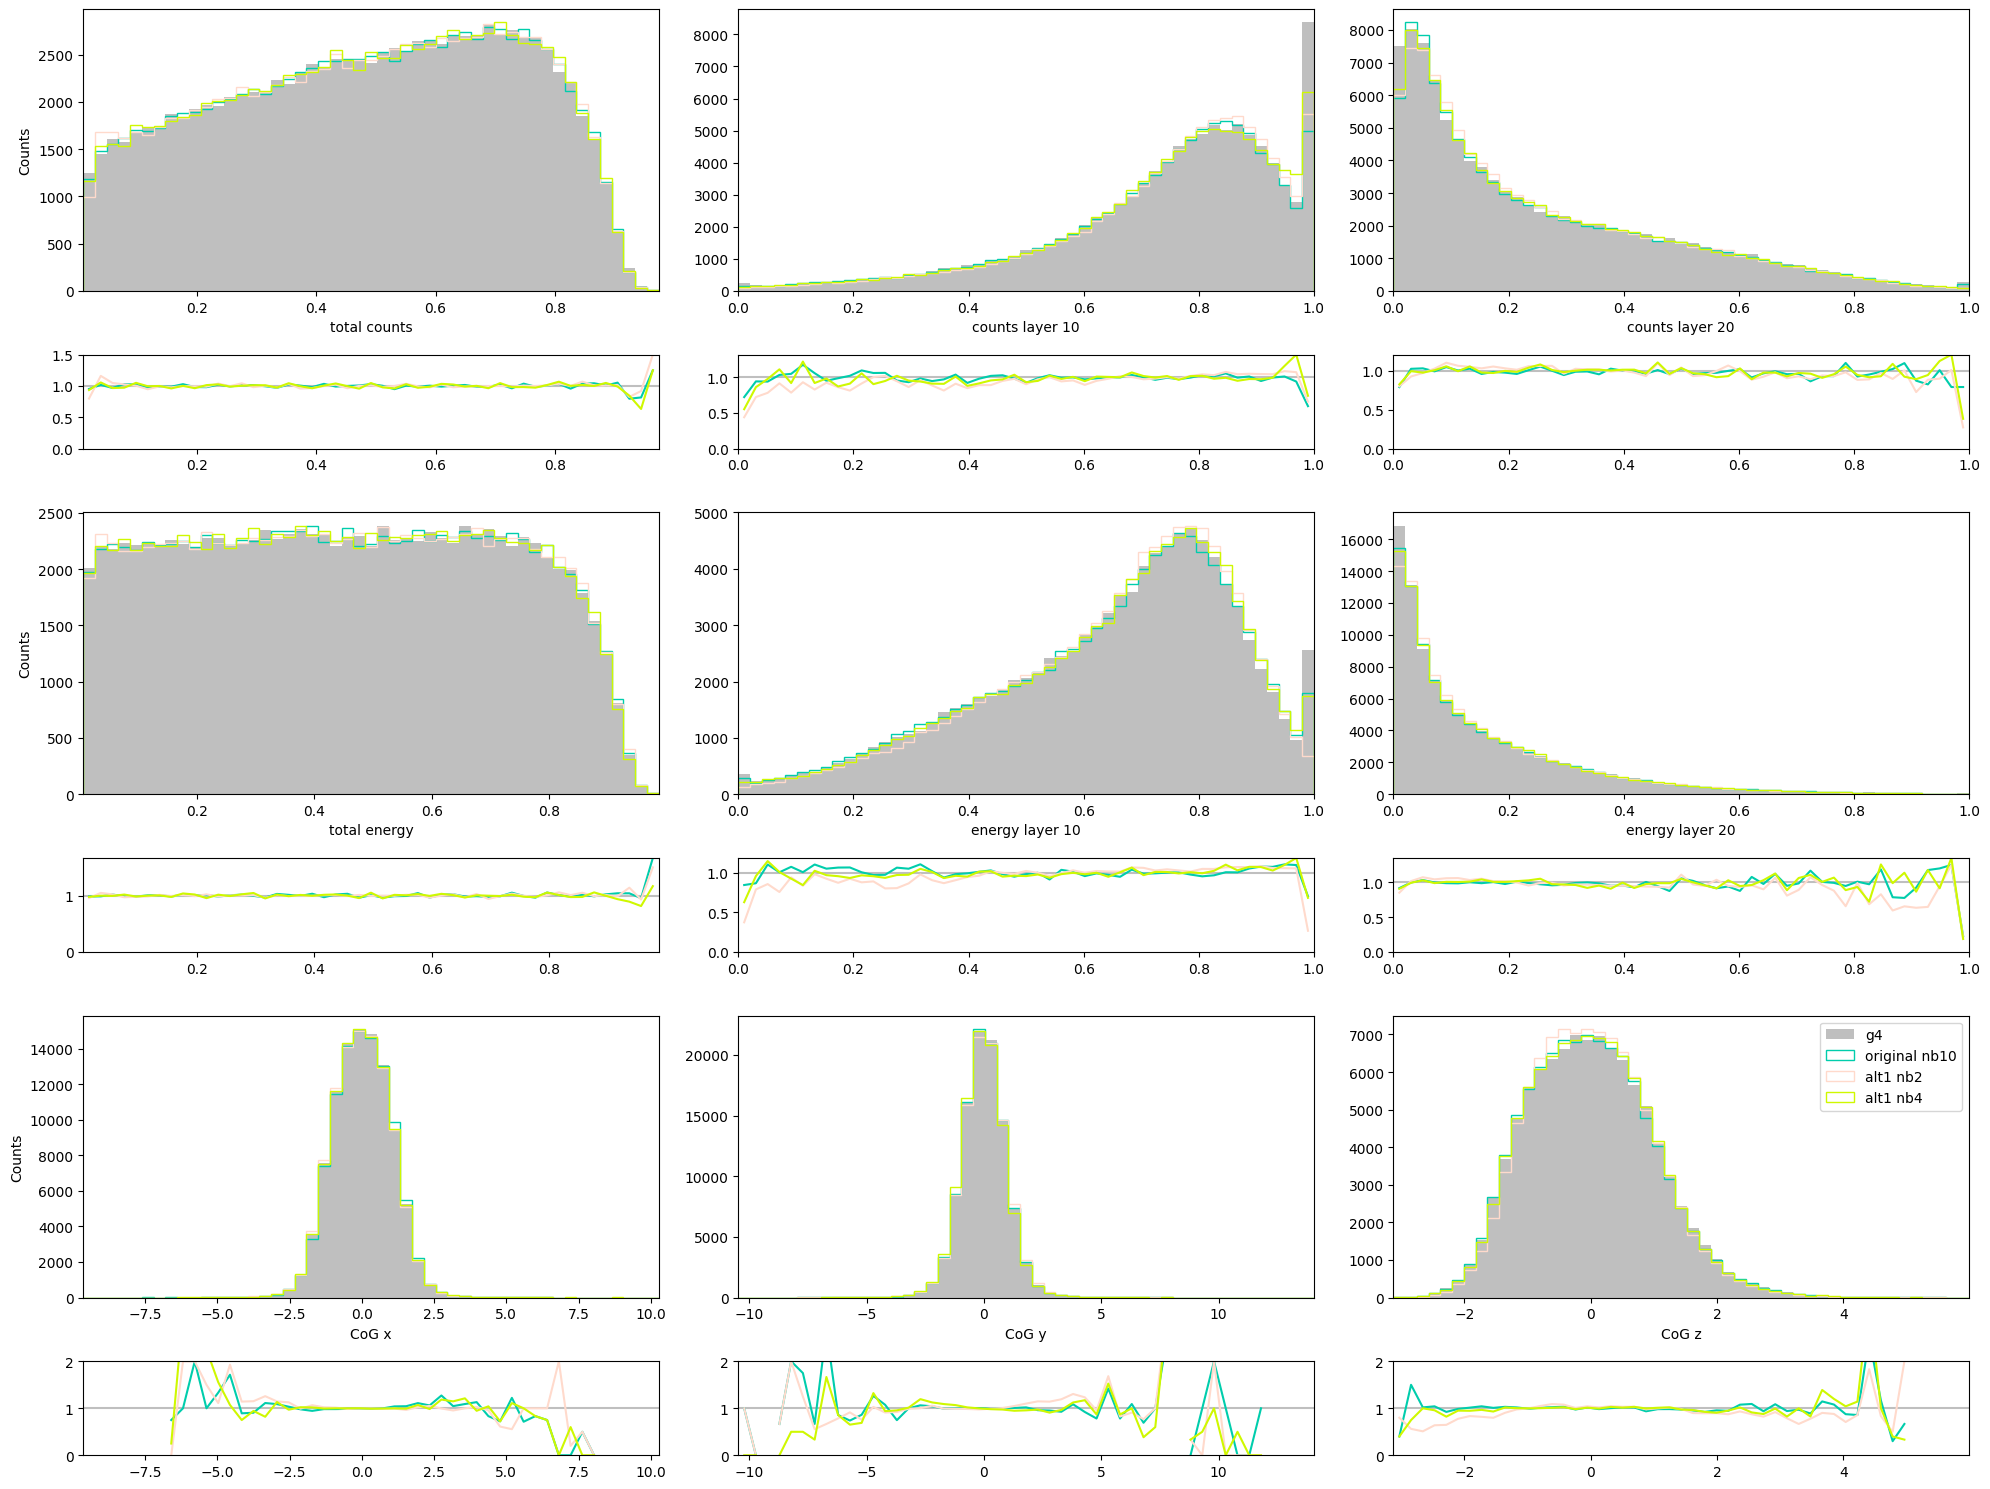

In [28]:
models_to_test = ["/data/dust/user/dayhallh/point-cloud-diffusion-data/showerFlow/sim-E1261AT600AP180-180/old/ShowerFlow_original_nb10_inputs36893488147419103231_best.pth",
                  "/data/dust/user/dayhallh/point-cloud-diffusion-data/showerFlow/sim-E1261AT600AP180-180/old/ShowerFlow_alt1_nb2_inputs36893488147419103231_best.pth",
                  "/data/dust/user/dayhallh/point-cloud-diffusion-data/showerFlow/sim-E1261AT600AP180-180/old/ShowerFlow_alt1_nb4_inputs36893488147419103231_best.pth"]
idxs = [existing['paths'].index(m) for m in models_to_test]
names = [m.split("/ShowerFlow_")[1].split("_inputs")[0] for m in models_to_test]
print(idxs)
print(names)

x_labels = ["total counts", "counts layer 10", "counts layer 20", "total energy", "energy layer 10", "energy layer 20", "CoG x", "CoG y", "CoG z"]
x_idxs = [0, -50, -40, 1, -20, -10, 2, 3, 4]
assert len(x_idxs) == len(x_labels)
truth_data = np.load(g4_path)['targets'][:, x_idxs].T

ratio_plots = plotting.RatioPlots(x_labels, truth_data)


for i, (idx, name) in enumerate(zip(idxs, names)):
    name = name.replace('_', " ")
    data = np.load(paths[idx])['uncalebrated'][:, x_idxs].T
    ratio_plots.add_comparison(data, name, plotting.nice_hex[3][i*2])

ratio_plots.finalise()


[17, 15, 10]
['original_nb10', 'alt1_nb2', 'alt1_nb10']


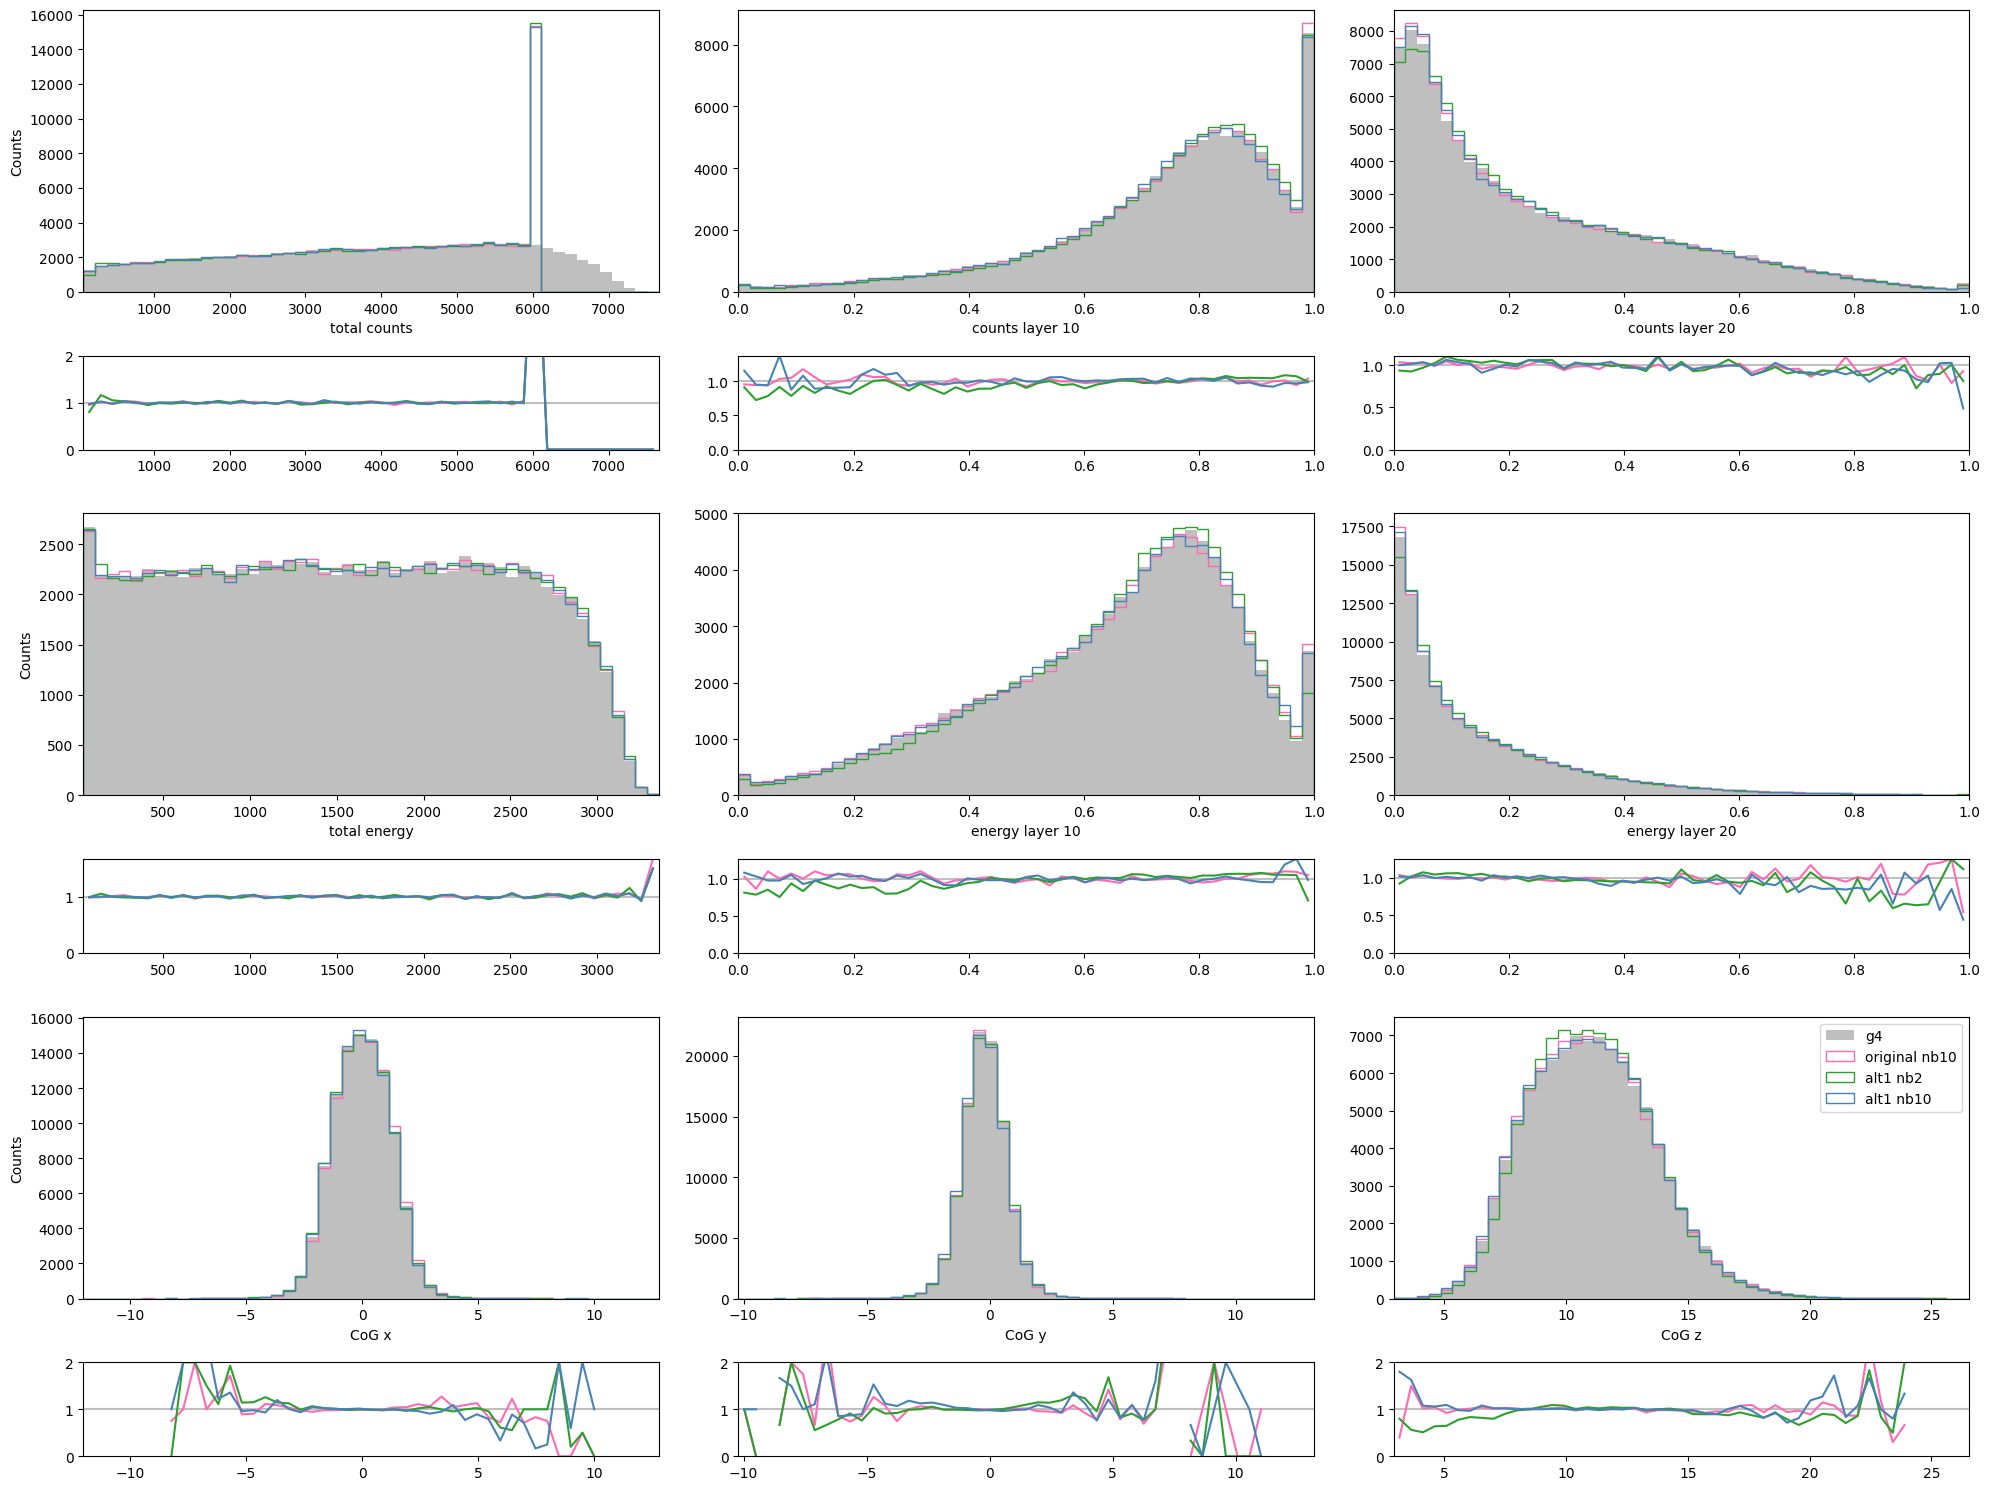

In [33]:
models_to_test = ["/data/dust/user/dayhallh/point-cloud-diffusion-data/showerFlow/sim-E1261AT600AP180-180/old/ShowerFlow_original_nb10_inputs36893488147419103231_best.pth",
                  "/data/dust/user/dayhallh/point-cloud-diffusion-data/showerFlow/sim-E1261AT600AP180-180/old/ShowerFlow_alt1_nb2_inputs36893488147419103231_best.pth",
                  "/data/dust/user/dayhallh/point-cloud-diffusion-data/showerFlow/sim-E1261AT600AP180-180/old/ShowerFlow_alt1_nb10_inputs36893488147419103231_best.pth"]
idxs = [existing['paths'].index(m) for m in models_to_test]
names = [m.split("/ShowerFlow_")[1].split("_inputs")[0] for m in models_to_test]
print(idxs)
print(names)

x_labels = ["total counts", "counts layer 10", "counts layer 20", "total energy", "energy layer 10", "energy layer 20", "CoG x", "CoG y", "CoG z"]
x_idxs = [0, -50, -40, 1, -20, -10, 2, 3, 4]
assert len(x_idxs) == len(x_labels)
truth_data = np.load(g4_path)['targets'][:]
calebrated = showerflow_utils.truescale_showerflow_output(truth_data, config)
calebrated = np.concatenate([np.atleast_2d(c).reshape((len(c), -1)) for c in calebrated if c is not None], axis=-1)
truth_data = calebrated[:, x_idxs].T


ratio_plots = plotting.RatioPlots(x_labels, truth_data)

colours = ['hotpink', 'tab:green', 'steelblue']
for i, (idx, name) in enumerate(zip(idxs, names)):
    name = name.replace('_', " ")
    data = np.load(paths[idx])['calebrated'][:, x_idxs].T
    ratio_plots.add_comparison(data, name, colours[i]) #plotting.nice_hex[3][i*2])

ratio_plots.finalise()
plt.savefig("NotEnoughPnts.png")



[4, 5, 9]
['original_nb10', 'alt1_nb2', 'alt1_nb10']


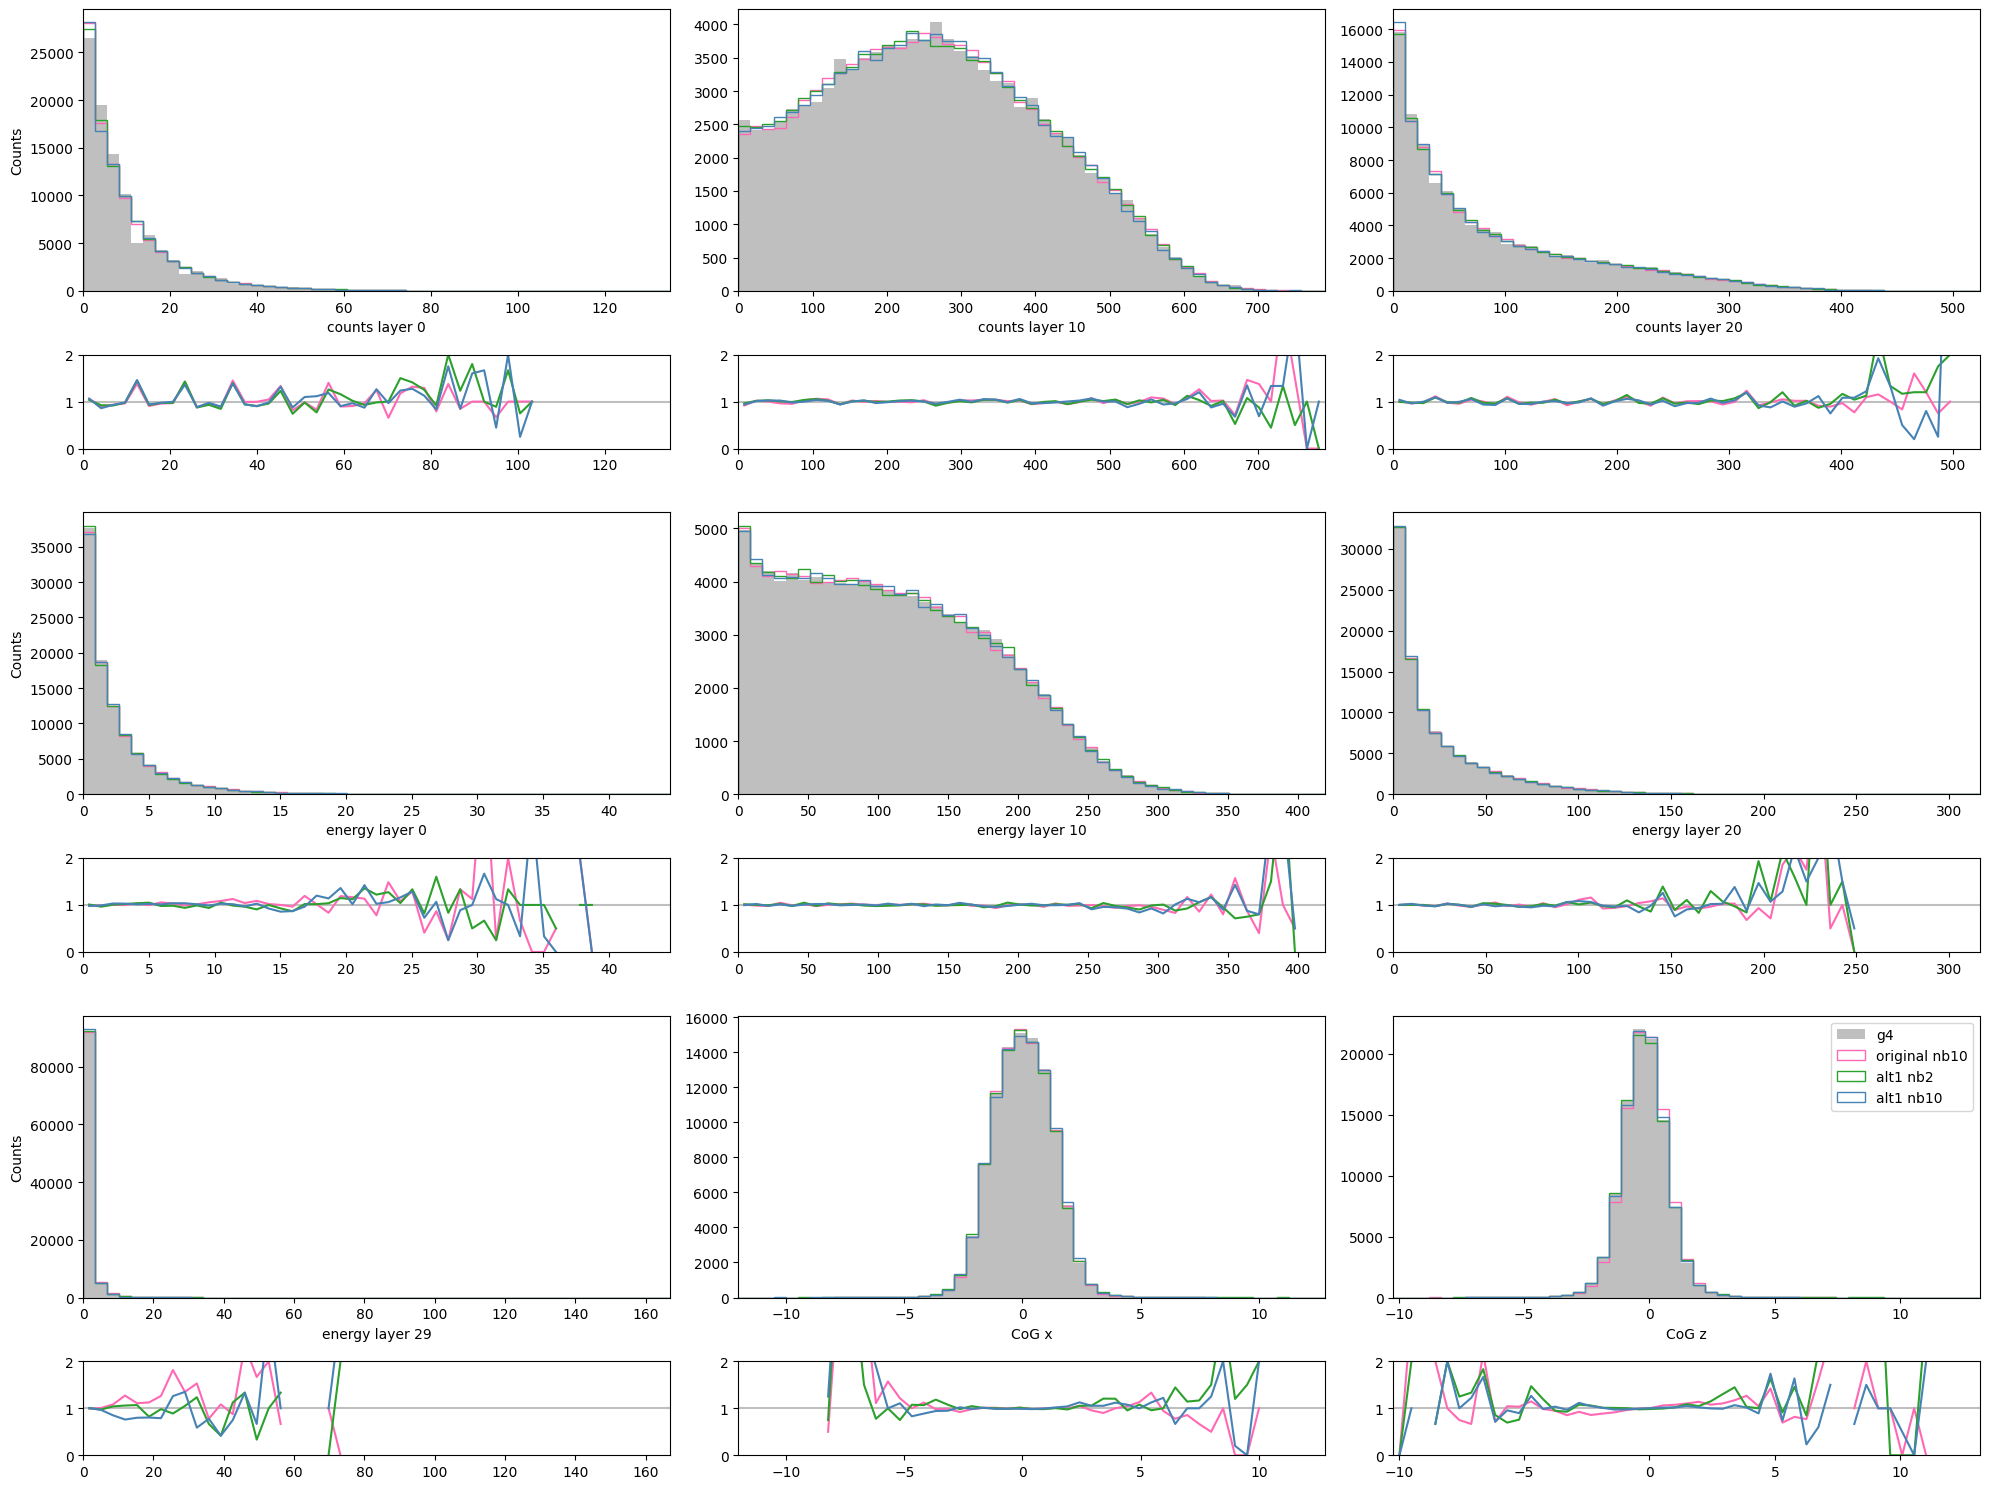

In [34]:
models_to_test = ["/data/dust/user/dayhallh/point-cloud-diffusion-data/showerFlow/sim-E1261AT600AP180-180/ShowerFlow_original_nb10_inputs8070450532247928831_fnorms_best.pth",
                  "/data/dust/user/dayhallh/point-cloud-diffusion-data/showerFlow/sim-E1261AT600AP180-180/ShowerFlow_alt1_nb2_inputs8070450532247928831_fnorms_best.pth",
                  "/data/dust/user/dayhallh/point-cloud-diffusion-data/showerFlow/sim-E1261AT600AP180-180/ShowerFlow_alt1_nb10_inputs8070450532247928831_fnorms_best.pth"]
idxs = [existing['paths'].index(m) for m in models_to_test]
names = [m.split("/ShowerFlow_")[1].split("_inputs")[0] for m in models_to_test]
print(idxs)
print(names)

x_labels = ["counts layer 0", "counts layer 10", " counts layer 20", "energy layer 0", "energy layer 10", "energy layer 20", "energy layer 29", "CoG x", "CoG z"]
x_idxs = [-60, -50, -40, -30, -20, -10, -1, 0, 1]
assert len(x_idxs) == len(x_labels)

truth_data = np.load(g4_path)['targets_s'][:]
calebrated = showerflow_utils.truescale_showerflow_output(truth_data, config_s)
calebrated = np.concatenate([np.atleast_2d(c).reshape((len(c), -1)) for c in calebrated if c is not None], axis=-1)
truth_data = calebrated[:, x_idxs].T

ratio_plots = plotting.RatioPlots(x_labels, truth_data)


for i, (idx, name) in enumerate(zip(idxs, names)):
    name = name.replace('_', " ")
    data = np.load(paths[idx])['calebrated'][:, x_idxs].T
    ratio_plots.add_comparison(data, name, colours[i]) #plotting.nice_hex[0][i*2])

ratio_plots.finalise()
plt.savefig("Working.png")

